# Тестовое задание

Требуется разработать алгоритм максимизации функции k на ориентированном мультиграфе (ССиТ).

Построение алгоритма будет выполняться в 2 этапа:
1. Написание движка для нахождения функции k на заданном ориентированном мультиграфе (ССиТ)
2. Оптимизация функции k

### Этап 1: Написание движка для нахождения функции k на заданном ориентированном мультиграфе

Код определяет классы для графа, состоящего из вершин и ребер, со специальными узлами для скважин и стока. Затем он создает граф, находит все ребра, которые соединяют скважины со стоком, и вычисляет дебиты через ребра в трубопроводе для скважин

Классы для графа включают класс Vertex, класс Edge и специальные классы Well и Drain, которые наследуются от класса Vertex. Класс Vertex имеет атрибут idx для хранения индекса вершины, атрибут edge_input для хранения списка входящих ребер и атрибут Q для хранения дебита вершины. Класс Edge имеет атрибут idx для хранения индекса ребра, а также атрибуты vertex1 и vertex2 для хранения вершин на обоих концах ребра. Классы Well и Drain имеют дополнительные атрибуты для хранения параметров дебита, специфичных для этих узлов

Функция create_graph() создает график, запрашивая у пользователя количество скважин (начальных вершин графа), промежуточных узлов (Vertex) и общее количество ребер, создавая экземпляры соответствующих классов для представления этих узлов и ребер. Ввод производится последовательно, в соответствии с направлением графа. Затем функция обновляет дебиты через вершины и ребра до тех пор, пока все ребра и узлы не обретут его значения.


Функция find_pipes() принимает узел скважины и список всех ребер на граф, и возвращает список всех ребер, которые соединяют скважину со стоком. Эта функция используется для нахождения суммы всех потерь на трубах от скважины до стока

Функция find_Q_well(p0) принимает значение давления на стоке и возвращает систему уравнений, которые будут использованы для решения и нахождения значения дебитов каждой скважины на графе

In [1]:
from sympy import symbols, Eq, solve

# Создание классов вершин и ребр графа. Скважины и сток будут особыми узлами с отдельными классами
class Well:
    def __init__(self, idx, alpha, const, Q):
        self.idx = idx
        self.alpha = alpha
        self.const = const
        self.Q = Q
          
class Vertex:
    def __init__(self, idx):
        self.idx = idx
        self.edge_input = []
        self.Q = 0

    def update_Q(self):
        self.Q = sum(edge.Q_edge for edge in self.edge_input)

class Edge:
    def __init__(self, idx, vertex1, vertex2, length = 5, diameter = 2, roughness = 0.1, density = 1000):
        self.idx = idx
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.length = length
        self.diameter = diameter
        self.roughness = roughness
        self.density = density
        self.update_Q_edge()

    def update_Q_edge(self):
        self.Q_edge = self.vertex1.Q
        self.pressure_loss = self.density * self.length * self.Q_edge * self.roughness / self.diameter

class Drain:
    def __init__(self, p_0, alpha = 3, const = 10, idx=0):
        self.p_0 = p_0
        self.edge_input = []
        self.alpha = alpha
        self.const = const
        self.idx = idx
        self.Q_0 = self.alpha * self.p_0 + self.const

In [2]:
# Создание графа
def create_graph():
    alpha = 3
    const = 10
    # Количество скважин
    num_wells = int(input("Enter the number of Wells: "))
    wells = []
    
    # Создание списка из num_wells элементов - Q1, Q2, Q3
    flow_rate = []
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(num_wells)])
    
    counter = 0
    for i in range(num_wells):
        counter = counter + 1
        wells.append(Well(i+1, alpha, const, flow_rate[i]))

    # Количество вершин
    num_vertex = int(input("Enter the number of Vertex: "))
    vertex = []
    for i in range(num_vertex):
        vertex.append(Vertex(i + counter))

    # Сток
    drain = [Drain(100)]
    common_vertex = drain + wells + vertex # A common array of all vertices
    print(common_vertex)

    # Количество ребр (труб)
    num_edges = int(input("Enter the number of Edges: "))
    edges = []
    for i in range(num_edges):
        vertex1 = int(input("Enter the first vertex for edge {}: ".format(i + 1)))
        vertex2 = int(input("Enter the second vertex for edge {}: ".format(i + 1)))
        # length = float(input("Enter the length for edge {}: ".format(i + 1)))
        # diameter = float(input("Enter the diameter for edge {}: ".format(i + 1)))
        # roughness = float(input("Enter the roughness for edge {}: ".format(i + 1)))
        # edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2], length, diameter, roughness))
        edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2]))

    for edge in edges:
        edge.vertex2.edge_input.append(edge)
        
    # Обновление характеристик дебитов на узлах и гранях, после создания всех элементов графа и их связей
    while edges[num_edges-1].Q_edge == 0:
        for edge in edges:
            edge.update_Q_edge()

        for vert in vertex:
            vert.update_Q()

    return wells, vertex, drain, edges, flow_rate

In [3]:
wells, vertex, drain, edges, flow_rate = create_graph()

[<__main__.Drain object at 0x107d27a90>, <__main__.Well object at 0x10c52c1c0>, <__main__.Well object at 0x107d64850>, <__main__.Vertex object at 0x107d27010>, <__main__.Vertex object at 0x107d26830>]


ValueError: invalid literal for int() with base 10: ''

In [ ]:
# Нахождение всех граней графа, ведущих от скважины до стока
def find_pipes(well, edges, drain):
    pipes = []
    visited = set()
    queue = []
    queue.append(well)
    while queue:
        curr = queue.pop(0)
        visited.add(curr)
        for edge in edges:
            if edge.vertex1 == curr and edge.vertex2 not in visited:
                queue.append(edge.vertex2)
                pipes.append(edge)
                if edge.vertex2 == drain:
                    return pipes
    return pipes

In [ ]:
pipes_from_wells_to_drain = []
for well in wells:
    pipes_from_wells_to_drain.append(find_pipes(well, edges, drain[0]))

In [ ]:
# Проверка дебита на последней заданной трубе
print(pipes_from_wells_to_drain[1][-1].Q_edge)

Q1 + Q2


In [ ]:
alpha = drain[0].alpha
const = drain[0].const
p0 = drain[0].p_0

# Нахождение уравнений от-но дебитов каждой скважины
def find_Q_well(p0):
    p0 = p0
    Q_well = []
    for well in range(len(wells)):
        Q_well.append(alpha * (p0 + sum(edge.pressure_loss for edge in pipes_from_wells_to_drain[well])) + const)
    return Q_well

In [ ]:
p0 = drain[0].p_0
Q0_prev = 0
eps = 0.001

# Итерационный поиск Q0
while True:

    Q_well = find_Q_well(p0)
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(len(Q_well))])

    # Решение системы уравнений от-но Q скважин
    eqs = [Eq(Q_well[i], flow_rate[i]) for i in range(len(Q_well))]
    sol = solve(eqs, flow_rate)

    # Нахождение нового Q0
    Q0 = sum(sol.get(well) for well in flow_rate)

    # Проверка сходимости
    if abs(Q0 - Q0_prev) < eps:
        break

    Q0_prev = Q0

    # Нахождение нового p0
    p0 = (Q0-const)/alpha

print("Q0:", Q0)
print("p0:", p0)

Q0: -9.19437649726549e-8
p0: -3.33328737677481


In [ ]:
# Нахождение целевой функции
def find_k():
    k = Q0 - sum(edge.length*edge.diameter/edge.roughness for edge in edges)
    return k

k = find_k()
print("k function:", k)

k function: -500.000000091944


### Этап 2
1. дополните параметры труб (шероховатость, длину, диаметр)   +
2. индивидуальные параметры альфа и константа для каждой трубы +
3. график сходимости по итерациям
4. подобрать константы что бы числа были физичные

### Новое уравнение для лупингов:
1. пропорционально пропускной способности
2. функция потенциала проводимости, зависящая от потенциально возможного дебита

In [20]:
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve


# Создание классов вершин и ребр графа. Скважины и сток будут особыми узлами с отдельными классами
class Well:
    def __init__(self, idx, alpha, const, Q):
        self.idx = idx
        self.alpha = alpha
        self.const = const
        self.Q = Q
        self.edge_output = []
        self.Q_vertex_list = [self.Q]

class Vertex:
    def __init__(self, idx):
        self.idx = idx
        self.edge_input = []
        self.edge_output = []
        self.Q = 0
        self.Q_vertex_list = []
        self.visited = False
        self.k = []
        self.count = 0
        
    def update_Q(self):
        self.Q_vertex_list = self.Q_vertex_list + self.edge_input[self.count].vertex1.Q_vertex_list
        self.Q = self.Q + self.edge_input[self.count].Q_edge
        self.count += 1
        self.visited = False

class Edge:
    def __init__(self, idx, vertex1, vertex2, length, diameter, roughness, density = 1000):
        self.idx = idx
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.double_index = str(self.vertex1.idx) + str(self.vertex2.idx)
        self.length = length
        self.diameter = diameter
        self.roughness = roughness
        self.density = density
        self.pot = self.diameter / (self.roughness * self.length) # Коэффициент распределения дебита при разветвлении на графе с привязкой характеристик труб
        self.Q_edge = 0

    def update_Q_edge(self, k = None):
        if len(self.vertex1.edge_output)>1:
            self.x = symbols('x')
            self.eqs = Eq(self.x * sum(edge.pot for edge in self.vertex1.edge_output), 1)
            self.sol_x = solve(self.eqs, self.x)
            self.sol_x = self.sol_x[0]
            self.prop_koef = self.sol_x * self.pot
            
            for i in range(len(self.vertex1.Q_vertex_list)):
                self.Q_edge = self.Q_edge + self.vertex1.Q_vertex_list[i] * k[i]

            self.Q_edge = self.Q_edge * self.prop_koef
            self.pressure_loss = self.density * self.length * self.Q_edge * self.roughness / self.diameter

        else:
            self.Q_edge = self.vertex1.Q
            self.pressure_loss = self.density * self.length * self.Q_edge * self.roughness / self.diameter

class Drain:
    def __init__(self, p_0, alpha, const, idx=0):
        self.p_0 = p_0
        self.edge_input = []
        self.alpha = alpha
        self.const = const
        self.idx = idx
        self.visited = False
        self.Q_0 = self.alpha * self.p_0 + self.const


In [61]:
# Создание графа
def create_graph(p_0, dw_parameters, edge_parameters, edge_vertexes):
    # alpha = 3
    # const = 10

    # Сток
    # dw_parameters = [] # Alpha и Const для стока и скважин
    # alpha = int(input("Enter alpha for Drain: "))
    # const = int(input("Enter const for Drain: "))
    # dw_parameters.append([alpha, const]) # Drain Well Alpha and Const

    drain = [Drain(p_0, dw_parameters[0][0], dw_parameters[0][1])]

    # Количество скважин
    # num_wells = int(input("Enter the number of Wells: "))
    num_wells = len(dw_parameters) - 1
    wells = []
    
    # Создание списка из num_wells элементов - Q1, Q2, Q3
    flow_rate = []
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(num_wells)])
    
    counter = 0
    for i in range(num_wells):
        counter = counter + 1
        # alpha = int(input("Enter alpha for well {}: ".format(i + 1)))
        # const = int(input("Enter const for well {}: ".format(i + 1)))
        # dw_parameters.append([alpha, const])
        wells.append(Well(i+1, dw_parameters[i+1][0], dw_parameters[i+1][1], flow_rate[i]))

    # Количество дополнительных вершин
    num_vertex = int(input("Enter the number of Vertex: "))
    vertex = []
    for i in range(num_vertex):
        vertex.append(Vertex(i+1 + counter))

   
    common_vertex = drain + wells + vertex # A common array of all vertices
    print(common_vertex)

    # Количество ребр (труб)
    # num_edges = int(input("Enter the number of Edges: "))
    num_edges = len(edge_parameters)

    edges = []

    # edge_parameters = []
    # edge_vertexes = []

    for i in range(num_edges):
        # vertex1 = int(input("Enter the first vertex for edge {}: ".format(i + 1)))
        # vertex2 = int(input("Enter the second vertex for edge {}: ".format(i + 1)))
        # length = float(input("Enter the length for edge {}: ".format(i + 1)))
        # diameter = float(input("Enter the diameter for edge {}: ".format(i + 1)))
        # roughness = float(input("Enter the roughness for edge {}: ".format(i + 1)))
        # edge_parameters.append([length, diameter, roughness])
        # edge_vertexes.append([vertex1, vertex2])
        edges.append(Edge(i+1, common_vertex[edge_vertexes[i][0]], common_vertex[edge_vertexes[i][1]], edge_parameters[i][0], edge_parameters[i][1], edge_parameters[i][2]))

        # edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2]))

    for edge in edges:
        edge.vertex2.edge_input.append(edge)
        edge.vertex1.edge_output.append(edge)
        # print(edge.vertex1.edge_output)
        
    print(edges[-1].vertex1.edge_output)
    print(len(edges[0].vertex1.edge_output))
    print(len(edges[-1].vertex1.edge_output))


    counter_k = 0
    # for edge in edges:
    #     if len(edge.vertex1.edge_output) > 1:
    #         for i in range(len(edge.vertex1.Q_vertex_list)):
    #             counter_k = counter_k + 1
    #             k = k + symbols(['k{}'.format(counter_k)])
    # print(k)
        
    # Обновление характеристик дебитов на узлах и гранях, после создания всех элементов графа и их связей
    while edges[num_edges-1].Q_edge == 0:
        for edge in edges:
            if len(edge.vertex1.edge_output) > 1:
                print('edge '+ f'{edge.idx}' + ' Loop: ' + f'{edge.vertex1.Q_vertex_list}')
                print('edge '+ f'{edge.double_index}' + ' Loop: ' + f'{edge.vertex1.Q_vertex_list}')



                # for i in range(len(edge.vertex1.Q_vertex_list)):
                #     counter_k = counter_k + 1
                #     k = k + symbols(['k{}'.format(counter_k)])
                if edge.vertex1.k == []:
                    for i in range(len(edge.vertex1.Q_vertex_list)):
                        counter_k = counter_k + 1
                        edge.vertex1.k = edge.vertex1.k + symbols(['k{}'.format(counter_k)])


                edge.update_Q_edge(edge.vertex1.k)
                print(edge.Q_edge)


                if edge.vertex2.visited == False and edge.vertex2.idx != 0 :
                    edge.vertex2.update_Q()

            else:

                print('edge '+ f'{edge.idx}' + ' No Loop')
                edge.update_Q_edge()
                if edge.vertex2.visited == False and edge.vertex2.idx != 0 :
                    edge.vertex2.update_Q()
                # k.pop(0) - Неправильно

        # for vert in vertex:
        #     vert.update_Q()
    return wells, vertex, drain, edges, flow_rate, dw_parameters, edge_parameters, edge_vertexes, common_vertex

# Тестовые параметры для тестового графа (на 2 скважины, 3 узла, 5 ребр)
# Graph 1 
# dw_parameters = [[10, -50000], [20, -20e9], [30, -30e9]] # [[alpha, const]]
# edge_parameters = [[100.0, 2.0, 0.1], [120.0, 2.0, 0.1], [135.0, 2.0, 0.1], [96.0, 2.0, 0.1], [220.0, 5.0, 0.1]] #[[length, diametr, roughness]]
# edge_vertexes = [[1, 3], [2, 4], [3, 5], [4, 5], [5, 0]]

# Graph 2
# dw_parameters = [[100, 100], [10, 110], [40, -840], [32, -60], [16, 78]] # [[alpha, const]]
# edge_parameters = [[100.0, 2.0, 0.1], [80.0, 2.0, 0.1], [70.0, 2.0, 0.1], [85.0, 2.0, 0.1], [120.0, 5.0, 0.1], [60.0, 5.0, 0.1], [92.0, 5.0, 0.1], [320.0, 5.0, 0.1]] #[[length, diametr, roughness]]
# edge_vertexes = [[1, 5], [2, 5], [3, 6], [4, 7], [5, 8], [6, 8], [7, 8], [8, 0]]

# # Graph 3 with loop
# dw_parameters = [[10, -500], [10, -500], [10, -500]] # [[alpha, const]]
# edge_parameters = [[-11.0, 1.5, 0.1], [-10.0, 1.5, 0.1], [-8.0, 1.8, 0.1], [-9.0, 1.8, 0.1], [-16.0, 2.5, 0.1]] #[[length, diametr, roughness]]
# edge_vertexes = [[1, 3], [2, 3], [3, 4], [4, 0], [3, 0]]

# Original Graph
# dw_parameters = [[-10, 50], [-23, 300], [-60, 800], [-360, 500], [-200, 500], [-120, 500]] # [[alpha, const]] # Parameters of Wells + Drain
# dw_parameters = [[-10, 50000], [-23, 20e9], [-60, 30e9], [-36, 12e9], [-20, 6e7], [-12, 120000]] # [[alpha, const]] # Parameters of Wells + Drain
dw_parameters = [[10, -50000], [20, -20e9], [30, -30e9], [20, -20e9], [30, -30e9], [20, -20e9]] # [[alpha, const]] # Parameters of Wells + Drain


edge_parameters = [[11.0, 1.5, 0.1], [10.0, 1.5, 0.1], [8.0, 1.8, 0.1], [9.0, 1.8, 0.1], [16.0, 2.5, 0.1], [11.0, 1.5, 0.1], [10.0, 1.5, 0.1], [8.0, 1.8, 0.1], [9.0, 1.8, 0.1], [16.0, 2.5, 0.1]] #[[length, diametr, roughness]]
edge_vertexes = [[1, 6], [2, 6], [3, 7], [4, 8], [5, 8], [6, 7], [8, 7], [7, 9], [8, 9], [9, 0]] # Vertex Conections

p_0 = 100

# Создание графа
wells, vertex, drain, edges, flow_rate, dw_parameters, edge_parameters, edge_vertexes, common_vertex = create_graph(p_0, dw_parameters, edge_parameters, edge_vertexes)

[<__main__.Drain object at 0x0000023CCF32EA60>, <__main__.Well object at 0x0000023CCF3DA790>, <__main__.Well object at 0x0000023CCF423190>, <__main__.Well object at 0x0000023CCF423610>, <__main__.Well object at 0x0000023CCF423130>, <__main__.Well object at 0x0000023CCF4232B0>, <__main__.Vertex object at 0x0000023CCF4C2C40>, <__main__.Vertex object at 0x0000023CCF4235E0>, <__main__.Vertex object at 0x0000023CCF4D8D30>, <__main__.Vertex object at 0x0000023CCF407AC0>]
1
1
edge 1 No Loop
edge 2 No Loop
edge 3 No Loop
edge 4 No Loop
edge 5 No Loop
edge 6 No Loop
edge 7 Loop: [Q4, Q5]
edge 87 Loop: [Q4, Q5]
0.428571428571429*Q4*k1 + 0.428571428571429*Q5*k2
edge 8 No Loop
edge 9 Loop: [Q4, Q5]
edge 89 Loop: [Q4, Q5]
0.571428571428571*Q4*k1 + 0.571428571428571*Q5*k2
edge 10 No Loop


In [62]:
# Check Debits on Edges
for edge in edges:
    print('edge ' + f'{edge.double_index}: ' + f'{edge.Q_edge}')
    if len(edge.vertex1.edge_output) > 1:
        print(edge.prop_koef)

edge 16: Q1
edge 26: Q2
edge 37: Q3
edge 48: Q4
edge 58: Q5
edge 67: Q1 + Q2
edge 87: 0.428571428571429*Q4*k1 + 0.428571428571429*Q5*k2
0.428571428571429
edge 79: Q1 + Q2 + Q3 + 0.428571428571429*Q4*k1 + 0.428571428571429*Q5*k2
edge 89: 0.571428571428571*Q4*k1 + 0.571428571428571*Q5*k2
0.571428571428571
edge 90: Q1 + Q2 + Q3 + 1.0*Q4*k1 + 1.0*Q5*k2


In [92]:
# print(vertex[0].edge_input)

In [63]:
# Finding all graph edges leading from the well to the drain
# def find_pipes(well, edges, drain):
#     pipes = []
#     visited = set()
#     stack = []
#     stack.append((well, []))
#     while stack:
#         curr, path = stack.pop()
#         visited.add(curr)
#         for edge in edges:
#             if edge.vertex1 == curr and edge.vertex2 not in visited:
#                 new_path = path[:] + [edge]
#                 if edge.vertex2 == drain:
#                     pipes.append(new_path)
#                 else:
#                     stack.append((edge.vertex2, new_path))
#     return pipes
def find_pipes(well, edges, drain):
    pipes = []
    stack = []
    stack.append((well, []))
    while stack:
        curr, path = stack.pop()
        for edge in edges:
            if edge.vertex1 == curr and edge.vertex2 not in path:  # Modify this line
                new_path = path[:] + [edge]
                if edge.vertex2 == drain:
                    pipes.append(new_path)
                else:
                    stack.append((edge.vertex2, new_path))
    return pipes


pipes_from_wells_to_drain = []
for well in wells:
    pipes_from_wells_to_drain.append(find_pipes(well, edges, drain[0]))

print(pipes_from_wells_to_drain)
print(len(pipes_from_wells_to_drain))
for well in range(len(wells)):
    print(len(pipes_from_wells_to_drain[well]))

[[[<__main__.Edge object at 0x0000023CBF4F5C70>, <__main__.Edge object at 0x0000023CBF4E3670>, <__main__.Edge object at 0x0000023CBF4E3790>, <__main__.Edge object at 0x0000023CCF41D3D0>]], [[<__main__.Edge object at 0x0000023CBF4E3040>, <__main__.Edge object at 0x0000023CBF4E3670>, <__main__.Edge object at 0x0000023CBF4E3790>, <__main__.Edge object at 0x0000023CCF41D3D0>]], [[<__main__.Edge object at 0x0000023CBF4E3940>, <__main__.Edge object at 0x0000023CBF4E3790>, <__main__.Edge object at 0x0000023CCF41D3D0>]], [[<__main__.Edge object at 0x0000023CBF4E3E50>, <__main__.Edge object at 0x0000023CBF4E3E20>, <__main__.Edge object at 0x0000023CCF41D3D0>], [<__main__.Edge object at 0x0000023CBF4E3E50>, <__main__.Edge object at 0x0000023CBF4E3610>, <__main__.Edge object at 0x0000023CBF4E3790>, <__main__.Edge object at 0x0000023CCF41D3D0>]], [[<__main__.Edge object at 0x0000023CBF4E3EB0>, <__main__.Edge object at 0x0000023CBF4E3E20>, <__main__.Edge object at 0x0000023CCF41D3D0>], [<__main__.E

In [64]:
# Проверка путей:
for well in range(len(wells)):
    for way in range(len(pipes_from_wells_to_drain[well])):
        for edge in pipes_from_wells_to_drain[well][way]:
            print('edge: ' + f'{edge.double_index}')
        print('end way ------------')
    print('end well -----------')

edge: 16
edge: 67
edge: 79
edge: 90
end way ------------
end well -----------
edge: 26
edge: 67
edge: 79
edge: 90
end way ------------
end well -----------
edge: 37
edge: 79
edge: 90
end way ------------
end well -----------
edge: 48
edge: 89
edge: 90
end way ------------
edge: 48
edge: 87
edge: 79
edge: 90
end way ------------
end well -----------
edge: 58
edge: 89
edge: 90
end way ------------
edge: 58
edge: 87
edge: 79
edge: 90
end way ------------
end well -----------


In [22]:
# # Проверка дебитов на последних трубах
# print(pipes_from_wells_to_drain[0][0][-1].Q_edge)
# print(pipes_from_wells_to_drain[0][0][-1].idx)
# print(pipes_from_wells_to_drain[0][1][-1].Q_edge)
# print(pipes_from_wells_to_drain[0][1][-1].idx)

# for i in range(len(pipes_from_wells_to_drain[1][0])):
#     print(pipes_from_wells_to_drain[1][0][i].idx)
#     print(pipes_from_wells_to_drain[1][0][i].pressure_loss)

In [65]:
# Параметры alpha и const задаются непосредственно на скважинах, а не трубах !
p0 = drain[0].p_0
# Finding equations from each well's flow rate
def find_Q_well(p0, pipes_from_wells_to_drain):

    Q_well = []
    for well in range(len(wells)):
        for way in range(len(pipes_from_wells_to_drain[well])):
            pipes = pipes_from_wells_to_drain[well][way]
            pressure_loss = sum(edge.pressure_loss for edge in pipes)
            Q_well.append(wells[well].alpha * (p0 + pressure_loss) + wells[well].const)

    return Q_well

k_list = []
for vert in vertex:
    if vert.k != [pipes_from_wells_to_drain]:
        k_list = k_list + vert.k

# flow_rate = []
# for well in range(len(wells)):
#     for way in range(len(pipes_from_wells_to_drain[well])):
#         flow_rate = flow_rate + symbols(['Q{}'.format(well+1)])

print(flow_rate)
print(k_list)

[Q1, Q2, Q3, Q4, Q5]
[k1, k2]


In [66]:
Q_well = find_Q_well(p0, pipes_from_wells_to_drain)
print(Q_well)
print(flow_rate)

# flow_rate = []
# for well in range(len(wells)):
#     for way in range(len(pipes_from_wells_to_drain[well])):
#         flow_rate = flow_rate + symbols(['Q{}'.format(well+1)])
        
print(flow_rate)

# for i in range(len(Q_well)):
#     Q_well[i] = Q_well[i]- flow_rate[i]

[51022.2222222222*Q1 + 36355.5555555556*Q2 + 21688.8888888889*Q3 + 16609.5238095238*Q4*k1 + 16609.5238095238*Q5*k2 - 19999998000.0, 54533.3333333333*Q1 + 74533.3333333333*Q2 + 32533.3333333333*Q3 + 24914.2857142857*Q4*k1 + 24914.2857142857*Q5*k2 - 29999997000.0, 21688.8888888889*Q1 + 21688.8888888889*Q2 + 30577.7777777778*Q3 + 16609.5238095238*Q4*k1 + 16609.5238095238*Q5*k2 - 19999998000.0, 19200.0*Q1 + 19200.0*Q2 + 19200.0*Q3 + 27771.4285714286*Q4*k1 + 15000.0*Q4 + 27771.4285714286*Q5*k2 - 29999997000.0, 32533.3333333333*Q1 + 32533.3333333333*Q2 + 32533.3333333333*Q3 + 33485.7142857143*Q4*k1 + 15000.0*Q4 + 33485.7142857143*Q5*k2 - 29999997000.0, 12800.0*Q1 + 12800.0*Q2 + 12800.0*Q3 + 18514.2857142857*Q4*k1 + 18514.2857142857*Q5*k2 + 12800.0*Q5 - 19999998000.0, 21688.8888888889*Q1 + 21688.8888888889*Q2 + 21688.8888888889*Q3 + 22323.8095238095*Q4*k1 + 22323.8095238095*Q5*k2 + 12800.0*Q5 - 19999998000.0]
[Q1, Q2, Q3, Q4, Q5]
[Q1, Q2, Q3, Q4, Q5]


In [67]:
from sympy import symbols, lambdify
import numpy as np
from scipy.optimize import least_squares
def find_Q_drain_2(drain, p0, pipes_from_wells_to_drain, flow_rate, k_list):

    # flow_rate_origin = symbols(['Q{}'.format(i+1) for i in range(len(wells))])
    residual_history = []

    def residual(vars, *params):
        p0 = drain[0].p_0
        Q_well = find_Q_well(p0, pipes_from_wells_to_drain)
        # print('Q_well: ' + f'{Q_well}')
        # print('len(Q_well): ' + f'{len(Q_well)}')

        # Создание списка переменных для Q_well (Отличается размерность с обычным)
        flow_rate_multi = []
        for well in range(len(wells)):
            for _ in range(len(pipes_from_wells_to_drain[well])):
                flow_rate_multi = flow_rate_multi + symbols(['Q{}'.format(well+1)])
        # print('flow_rate_multi: '+ f'{flow_rate_multi}')

        # Вычитание правой части уравнения из левой
        for i in range(len(Q_well)):
            Q_well[i] = Q_well[i]- flow_rate_multi[i]
        # print(Q_well)

        # flow_rate_origin = symbols(['Q{}'.format(i+1) for i in range(len(wells))])
        # k_list = [k for vert in vertex if vert.k != pipes_from_wells_to_drain for k in vert.k]
        # common_list_var = flow_rate_origin + k_list
        common_list_var = flow_rate + k_list
        # print('common_list_var: ' + f'{common_list_var}')
        # print('Q_well: ' + f'{Q_well}')
        
        r = np.zeros(len(Q_well))
        for i in range(len(Q_well)):
            # Convert the symbolic expression to a numerical function
            Q_well_num = lambdify(common_list_var, Q_well[i], "numpy")
            
            # Evaluate the numerical function with the current variable values
            r[i] = Q_well_num(*vars)
        

        residual_norm = np.linalg.norm(r)
        residual_history.append(residual_norm)
        # print('r: ' + f'{r}')
        # print('len(r): ' + f'{len(r)}')
        return r
    
    # initial_guess = np.ones(len(flow_rate_origin) + len(k_list))  # Initial guess_1 for Q1, Q2, k1, k2
    # initial_guess = np.zeros(len(flow_rate_origin) + len(k_list))  # Initial guess_2 for Q1, Q2, k1, k2
    # initial_guess = np.random.randint(1, 15, len(flow_rate_origin) + len(k_list)).tolist()  # Initial guess_3 for Q1, Q2, k1, k2

    initial_guess = np.random.randint(1, 15, len(flow_rate) + len(k_list)).tolist()  # Initial guess_3 for Q1, Q2, k1, k2
    # print('initial_guess: ' + f'{initial_guess}')
    # print('len(initial_guess): ' + f'{len(initial_guess)}')


    result = least_squares(residual, initial_guess, method = 'lm')
    solution = result.x

    # # Split the solution into Q and k values
    # Q_values = solution[:len(flow_rate_origin)]
    # k_values = solution[len(flow_rate_origin):]

    Q_values = solution[:len(flow_rate)]
    k_values = solution[len(flow_rate):]
    alpha = drain[0].alpha
    const = drain[0].const
    # Поиск Q0
    Q0 = sum(Q_values)
    # Finding a new p0
    p0 = (Q0-const)/alpha
    
    return Q_values, k_values, Q0, p0, residual_history

# print(f'Q_values: {Q_values}')
# print(f'k_values: {k_values}')

In [25]:
# for i in range(len(pipes_from_wells_to_drain[1][1])):
#     print(pipes_from_wells_to_drain[1][1][i].idx)
#     print(pipes_from_wells_to_drain[1][1][i].Q_edge)
#     print(pipes_from_wells_to_drain[1][1][i].pressure_loss)
#     # print('Pressure Loss Well_1 Way_1: ', + str(pipes_from_wells_to_drain[1][1][i].pressure_loss))
#     # print('Pressure Loss Well_1 Way_2: ', + str(pipes_from_wells_to_drain[1][2][i].pressure_loss))
# print(vertex[1].Q)
# print(vertex[1].edge_input)
# print(vertex[1].edge_output)
# print(vertex[1].Q_vertex_list)

In [26]:
# def find_Q_drain(drain, p0, pipes_from_wells_to_drain, flow_rate, k_list):

#     alpha = drain[0].alpha
#     const = drain[0].const

#     Q_well = find_Q_well(p0, pipes_from_wells_to_drain)
#     print(Q_well)

#     flow_rate_origin = symbols(['Q{}'.format(i+1) for i in range(len(wells))])
#     common_list_var = flow_rate_origin + k_list

#     # Solving a system of equations from Q wells
#     eqs = [Eq(Q_well[i], flow_rate[i]) for i in range(len(Q_well))]
#     print(eqs)
#     print(common_list_var)
#     sol = solve(eqs, common_list_var)
#     print(sol)
#     # Finding a new Q0
#     Q0 = sum(sol.get(well) for well in flow_rate_origin)

#     # Finding a new p0
#     p0 = (Q0-const)/alpha
#     return Q0, p0, Q_well

In [ ]:
# import numpy as np
# from scipy.optimize import least_squares

# def residual(vars, *params):
#     Q1, Q2, k1, k2 = vars
#     r = np.zeros(4)
#     r[0] = 7332 * Q1 + 2623 * Q1 * k1 + 2623 * Q2 * k2 + 500
#     r[1] = 7332 * Q1 + 5574 * Q1 * k1 + 5574 * Q2 * k2 + 500
#     r[2] = 6665 * Q1 + 2623 * Q1 * k1 + 2623 * Q2 * k2 + 500
#     r[3] = 6665 * Q1 + 5574 * Q1 * k1 + 5574 * Q2 * k2 + 500
#     print(Q1)
#     return r

# initial_guess = np.array([1, 1, 1, 1])  # Initial guess for Q1, Q2, k1, k2
# result = least_squares(residual, initial_guess)
# Q1, Q2, k1, k2 = result.x

# print("Q1:", Q1)
# print("Q2:", Q2)
# print("k1:", k1)
# print("k2:", k2)

[65571584831.5143, 65571584831.5143, 65571584831.5143, 65571584831.51187, 65571584831.50917, 65571584831.505585, 65571584831.51204, 65571584831.491196, 65571584831.51245, 65571584831.49212, 28918447838.881516, 28918447838.642334, 28918447838.609802, 28918447838.72613, 28918447791.636513, 28918447353.287327, 28918447791.669167, 28918447353.335133, 8723206630.823614, 8723206630.982666, 8723206630.910437, 8723206631.003199, 8723206645.321547, 8723207032.52696, 8723206616.34444, 8723207032.445644, 7963767941.432769, 7963767940.555604, 7963767940.035096, 7963767941.4922, 7963767984.929701, 7963768148.141389, 7963767898.041747, 7963768148.0807, 36519986787.80523, 7815774589.829759, 7815774587.975537, 7815774587.173151, 7815774589.639818, 7815774600.346987, 7815774636.591891, 7815774579.411799, 7815774636.544775, 7860087733.575739, 7784700722.355124, 7784700720.252939, 7784700719.364846, 7784700722.116432, 7784700728.108549, 7784700747.568267, 7784700716.706983, 7784700747.52368, 7759009086.8

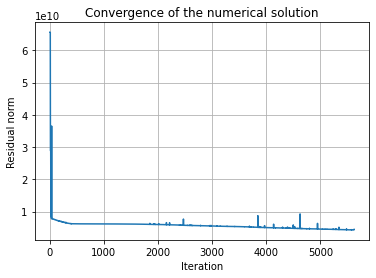

[65564154594.40846, 65564154594.40846, 65564154594.40846, 65564154594.398766, 65564154594.402054, 65564154594.396835, 65564154594.32346, 65564154594.368835, 65564154594.3253, 65564154594.36965, 89867018011.29211, 63713909914.74731, 63713909914.71553, 63713909914.716194, 63713909914.72158, 63713909895.90389, 63713909905.96278, 63713909895.93469, 63713909905.97347, 50147029326.27439, 50147029326.239365, 50147029326.239624, 50147029326.24674, 50147029170.06592, 50147029253.432335, 50147029170.14673, 50147029253.46483, 19752867241.380077, 19752867241.407814, 19752867241.407063, 19752867241.404602, 19752868009.16018, 19752867599.418354, 19752868008.92929, 19752867599.329082, 8153328806.880032, 8153328806.274322, 8153328806.051402, 8153328806.781166, 8153328743.523949, 8153328775.253663, 8153328743.468812, 8153328775.230847, 9024196087.436214, 8097181636.602762, 8097181636.035543, 8097181635.806351, 8097181636.53152, 8097181633.662432, 8097181635.103733, 8097181633.594359, 8097181635.075122,

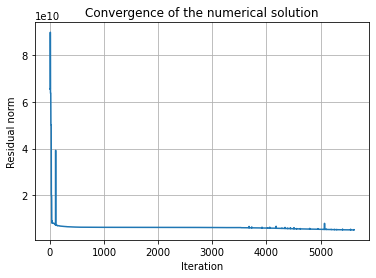

[65566478860.13665, 65566478860.13665, 65566478860.13665, 65566478860.131805, 65566478860.12383, 65566478860.1289, 65566478860.0537, 65566478860.12729, 65566478860.055336, 65566478860.1274, 35888140386.33945, 35888140386.51584, 35888140386.53973, 35888140386.46508, 35888141681.2398, 35888140541.78853, 35888141680.90565, 35888140541.61777, 8875247300.575298, 8875247298.099329, 8875247297.32925, 8875247299.996983, 8875246976.141613, 8875247233.961811, 8875246976.144983, 8875247233.963898, 49693648201.26363, 7980038051.976695, 7980038050.401588, 7980038049.799674, 7980038051.731506, 7980038004.683246, 7980038039.254688, 7980038004.62277, 7980038039.215189, 8053025051.228, 7944293600.728085, 7944293599.211016, 7944293598.603214, 7944293600.522095, 7944293587.712315, 7944293596.8732195, 7944293587.647876, 7944293596.831107, 7917688538.568598, 7917688536.582664, 7917688535.821332, 7917688538.262526, 7917688494.036481, 7917688523.089665, 7917688493.984461, 7917688523.0555105, 7871676471.25336

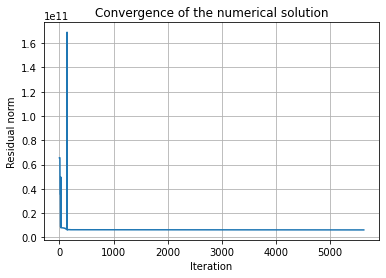

[65556006793.087875, 65556006793.087875, 65556006793.087875, 65556006793.070915, 65556006793.08404, 65556006793.08497, 65556006792.91684, 65556006793.008865, 65556006792.9197, 65556006793.01026, 172003967823.42697, 62515986314.110146, 62515986314.073364, 62515986314.08415, 62515986314.094604, 62515986283.18866, 62515986299.55492, 62515986283.225044, 62515986299.56658, 40264460436.12959, 40264460436.08932, 40264460436.09978, 40264460436.112175, 40264460185.41574, 40264460312.882454, 40264460185.51797, 40264460312.92568, 16339440565.606733, 16339440566.132639, 16339440566.229864, 16339440565.781435, 16339441241.4725, 16339440911.283329, 16339441241.270023, 16339440911.199232, 8372686447.853246, 8372686446.355577, 8372686445.862003, 8372686447.559395, 8372686286.393218, 8372686353.318651, 8372686286.372191, 8372686353.308681, 8830898286.071995, 7993802699.714718, 7993802698.3694515, 7993802697.846922, 7993802699.5275, 7993802674.3795395, 7993802683.290786, 7993802674.332483, 7993802683.26

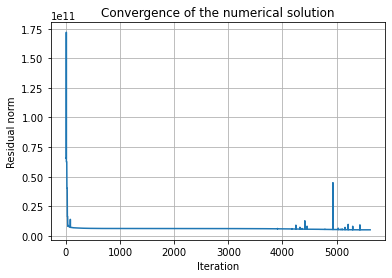

[65570462300.30506, 65570462300.30506, 65570462300.30506, 65570462300.289314, 65570462300.29225, 65570462300.299255, 65570462300.29357, 65570462300.29259, 65570462300.293976, 65570462300.293976, 23375262599.49305, 23375262599.218014, 23375262599.18753, 23375262599.32904, 23375262317.545826, 23375262279.61368, 23375262317.714005, 23375262279.632133, 13658699681.600376, 13658699677.989393, 13658699677.012112, 13658699680.61011, 13658699519.513271, 13658699198.53768, 13658699519.555069, 13658699198.559687, 8099860094.943023, 8099860091.089031, 8099860089.806421, 8099860094.151532, 8099860066.41457, 8099859821.851959, 8099860123.477141, 8099859821.841012, 13132603226.101244, 7775457551.022593, 7775457548.831533, 7775457547.912688, 7775457550.770017, 7775457554.072992, 7775457570.950093, 7775457547.998096, 7775457570.917034, 7723615989.124502, 7723615987.014759, 7723615986.05719, 7723615988.953856, 7723616008.073111, 7723616069.126494, 7723615970.226409, 7723616069.087484, 8006181307.411212

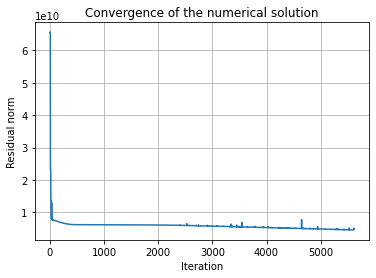

[65570337384.39033, 65570337384.39033, 65570337384.39033, 65570337384.38185, 65570337384.38007, 65570337384.38645, 65570337384.355835, 65570337384.38721, 65570337384.35706, 65570337384.38755, 9273957177.65377, 9273957177.465258, 9273957177.432863, 9273957177.559193, 9273956787.418575, 9273957142.074753, 9273956787.430506, 9273957142.076048, 8935747528.175415, 8935747526.425014, 8935747525.894957, 8935747527.74871, 8935747146.692081, 8935747517.532776, 8935747146.694845, 8935747517.532896, 8023293164.030501, 8023293161.947333, 8023293161.206878, 8023293163.651142, 8023293024.031693, 8023293160.862753, 8023293023.984766, 8023293167.1999, 7957918739.448186, 7957918734.976763, 7957918733.459484, 7957918738.555263, 7957918491.694157, 7957918710.972158, 7957918491.669052, 7957918767.930019, 7633927422.158867, 7633927419.657123, 7633927418.519725, 7633927421.9512005, 7633927489.045028, 7633927431.868431, 7633927488.98059, 7633927412.472786, 7788401596.201369, 7561966352.152971, 7561966349.052

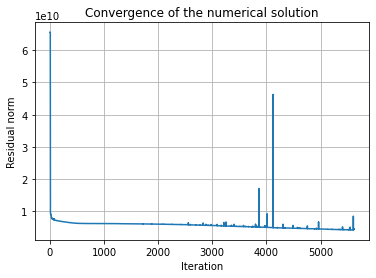

[65562145048.64733, 65562145048.64733, 65562145048.64733, 65562145048.63643, 65562145048.63452, 65562145048.64637, 65562145048.57394, 65562145048.563126, 65562145048.57619, 65562145048.56418, 95456034141.90622, 63591931397.84596, 63591931397.81496, 63591931397.81067, 63591931397.832146, 63591931384.04711, 63591931382.19165, 63591931384.06796, 63591931382.20754, 49067686913.784996, 49067686913.75075, 49067686913.746, 49067686913.76927, 49067686797.377625, 49067686785.19473, 49067686797.452324, 49067686785.23641, 25632874140.417824, 25632874140.447968, 25632874140.451393, 25632874140.433327, 25632874740.598797, 25632874801.75684, 25632874740.401966, 25632874801.638145, 8110337091.998255, 8110337091.486855, 8110337091.281336, 8110337091.932405, 8110337085.300859, 8110337082.545269, 8110337085.250382, 8110337082.506309, 8827561243.544762, 8093039853.195494, 8093039852.606923, 8093039852.366898, 8093039853.123129, 8093039851.312443, 8093039850.340295, 8093039851.263735, 8093039850.300512, 8

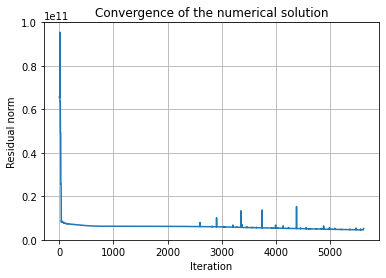

[65565413227.04602, 65565413227.04602, 65565413227.04602, 65565413227.03633, 65565413227.02808, 65565413227.032455, 65565413226.96933, 65565413227.030304, 65565413226.97117, 65565413227.031235, 141484649675.44046, 63536962921.161644, 63536962921.12502, 63536962921.11357, 63536962921.13088, 63536962896.51422, 63536962915.572556, 63536962896.547905, 63536962915.57767, 47239273174.36637, 47239273174.32633, 47239273174.31433, 47239273174.333664, 47239272965.29511, 47239273111.52327, 47239272965.389275, 47239273111.558, 28895259757.17626, 28895259757.60872, 28895259757.710037, 28895259757.326538, 28895260770.78593, 28895260068.51918, 28895260770.54287, 28895260068.444565, 8222750555.320535, 8222750555.095202, 8222750554.9689665, 8222750555.327437, 8222750675.316125, 8222750591.6848755, 8222750675.2114, 8222750591.653296, 8184507344.8587475, 8184507343.404499, 8184507342.890659, 8184507344.590402, 8184507205.35112, 8184507303.458101, 8184507205.314499, 8184507303.447207, 7989999541.962236, 7

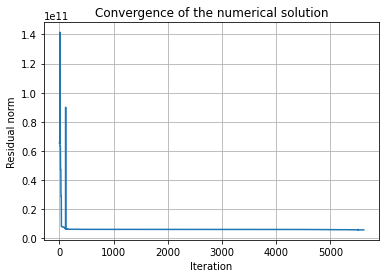

[65561739597.10633, 65561739597.10633, 65561739597.10633, 65561739597.1039, 65561739597.09864, 65561739597.096634, 65561739597.06115, 65561739596.982956, 65561739597.06197, 65561739596.98435, 86237816639.42906, 63637671986.97939, 63637671986.95804, 63637671986.95053, 63637671986.95763, 63637671978.72447, 63637671966.4543, 63637671978.75496, 63637671966.471054, 48684948579.436676, 48684948579.41215, 48684948579.40416, 48684948579.412994, 48684948497.72408, 48684948410.496086, 48684948497.776054, 48684948410.54503, 30062120233.711697, 30062120233.736626, 30062120233.743507, 30062120233.735394, 30062120677.779964, 30062121137.0659, 30062120677.608723, 30062121136.92965, 8355076949.790536, 8355076949.70647, 8355076949.644592, 8355076949.809247, 8355077014.113532, 8355077105.251566, 8355077014.039842, 8355077105.181979, 8173837093.464286, 8173837092.394574, 8173837092.009332, 8173837093.274602, 8173837063.698244, 8173836970.409038, 8173837063.680184, 8173836970.380126, 7998395836.046861, 79

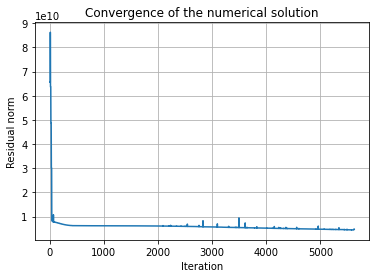

[65561283277.54127, 65561283277.54127, 65561283277.54127, 65561283277.530365, 65561283277.524605, 65561283277.53157, 65561283277.47556, 65561283277.44908, 65561283277.476585, 65561283277.450714, 123212038212.3641, 63107560351.37115, 63107560351.33815, 63107560351.329765, 63107560351.34736, 63107560335.73513, 63107560330.358696, 63107560335.7764, 63107560330.371796, 42252171372.07575, 42252171372.03928, 42252171372.03032, 42252171372.05005, 42252171216.59145, 42252171182.523834, 42252171216.66205, 42252171182.57901, 19037569662.20465, 19037569662.771645, 19037569662.895184, 19037569662.39595, 19037570134.49051, 19037570296.072594, 19037570134.327305, 19037570295.95912, 8280627999.617831, 8280627998.188854, 8280627997.696937, 8280627999.343441, 8280627928.652391, 8280627849.413342, 8280627928.635854, 8280627849.395206, 8320783525.198639, 7971364539.234061, 7971364537.569028, 7971364536.928321, 7971364538.983906, 7971364526.013363, 7971364485.451484, 7971364525.996152, 7971364485.417413, 

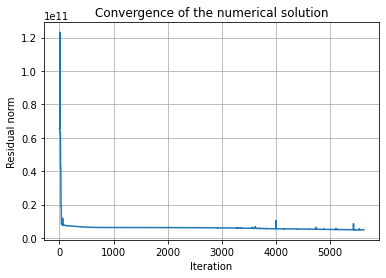

Q0: -1848983.9162077869
p0: -179898.39162077868


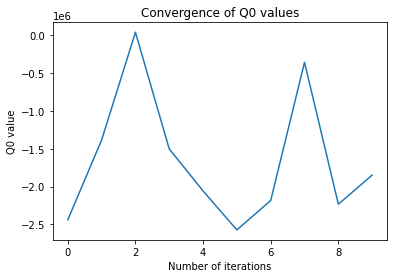

k function: -1851025.9162077869


In [68]:
Q0_prev = drain[0].Q_0
eps = 0.001

iterations = []
Q0_values = []

# set the maximum number of iterations
max_iterations = 10

# Итерационный поиск
i = 0
while i < max_iterations:
    # Q0, p0, Q_well = find_Q_drain(drain, p0, pipes_from_wells_to_drain, flow_rate, k_list)
    Q_values, k_values, Q0, p0, residual_history = find_Q_drain_2(drain, p0, pipes_from_wells_to_drain, flow_rate, k_list)

    print(residual_history)
    plt.plot(residual_history)
    plt.xlabel('Iteration')
    plt.ylabel('Residual norm')
    plt.title('Convergence of the numerical solution')
    plt.grid(True)
    plt.show()

    iterations.append(i)
    Q0_values.append(Q0)
    if abs(Q0 - Q0_prev) < eps:
        break

    Q0_prev = Q0

    i += 1

print("Q0:", Q0)
print("p0:", p0)

plt.plot(iterations, Q0_values)
# plt.semilogy() 
plt.xlabel('Number of iterations')
plt.ylabel('Q0 value')
plt.title('Convergence of Q0 values')
plt.show()

# Plot the residual history
# plt.plot(residual_history)
# plt.xlabel("Iteration")
# plt.ylabel("Sum of squared residuals")
# plt.title("Convergence of the numerical method")
# plt.show()

# Нахождение целевой функции
def find_k(Q0, edges):
    k = Q0 - sum(edge.length * edge.diameter/edge.roughness for edge in edges)
    return k

k = find_k(Q0, edges)
print("k function:", k)